In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import statistics
import os, torch
import numpy as np
import pandas as pd
import scienceplots
import h5py
from tqdm.notebook import tqdm 

plt.style.use(['science', 'ieee'])
plt.rcParams["text.usetex"] = False
plt.rcParams['figure.figsize'] = 6, 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder
from torch.nn import TransformerDecoder
import math

lr = 0.0001
dims = 16

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model, dtype=torch.float)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model).float() * (-math.log(10000.0) / d_model))
        pe += torch.sin(position * div_term)
        pe += torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x, pos=0):
        x = x + self.pe[pos:pos+x.size(0)]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=16, dropout=0):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU(True)

    def forward(self, src,src_mask=None, src_key_padding_mask=None, is_causal=None):
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        return src

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=16, dropout=0):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU(True)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt2 = self.self_attn(tgt, tgt, tgt)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.multihead_attn(tgt, memory, memory)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt


# Proposed Model + Self Conditioning + Adversarial + MAML (VLDB 22)
class TranAD(nn.Module):
    def __init__(self, feats):
        super(TranAD, self).__init__()
        self.name = 'TranAD'
        self.lr = lr
        self.batch = 2048
        self.n_feats = feats
        self.n_window = 10
        self.n_window_start = self.n_window
        self.n_window_slide = 1


        self.pos_encoder = PositionalEncoding(2 * feats, 0.1, self.n_window)
        encoder_layers = TransformerEncoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=128, dropout=0.1)
        self.transformer_encoder = TransformerEncoder(encoder_layers, 1)
        decoder_layers1 = TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=128, dropout=0.1)
        self.transformer_decoder1 = TransformerDecoder(decoder_layers1, 1)
        decoder_layers2 = TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=128, dropout=0.1)
        self.transformer_decoder2 = TransformerDecoder(decoder_layers2, 1)
        self.fcn = nn.Sequential(nn.Linear(2 * feats, feats), nn.Sigmoid())

    def encode(self, src, c, tgt):
        src = torch.cat((src, c), dim=2)
        src = src * math.sqrt(self.n_feats)
        src = self.pos_encoder(src)
        memory = self.transformer_encoder(src)
        tgt = tgt.repeat(1, 1, 2)
        return tgt, memory

    def forward(self, src, tgt):
        # Phase 1 - Without anomaly scores
        c = torch.zeros_like(src)
        x1 = self.fcn(self.transformer_decoder1(*self.encode(src, c, tgt)))
        x12 = self.fcn(self.transformer_decoder2(*self.encode(src, c, tgt)))
        # Phase 2 - With anomaly scores
        c = (x1 - src) ** 2
        x2 = self.fcn(self.transformer_decoder2(*self.encode(src, c, tgt)))
        return x1, x2, x12

class AlladiCNNLSTM(nn.Module):
    def __init__(self, feats):
        super(AlladiCNNLSTM, self).__init__()
        self.name = 'AlladiCNNLSTM'
        self.batch = 2048
        self.lr = lr
        self.n_feats = feats
        self.n_window = 10
        self.n_window_slide = 1
        self.n_window_start = self.n_window
        self.n_hidden = 256
        self.n_layers = 4

        # Define the CNN layers
        self.cnn = nn.Conv1d(feats, 20, kernel_size=3)

        # Define the LSTM layers
        self.lstm = nn.LSTM(20, self.n_hidden, self.n_layers, batch_first=True)

        # Fully connected layer
        # self.fc = nn.Sequential(nn.Linear(20 * self.n_hidden, self.n_feats), nn.Sigmoid())
        self.fc = nn.Sequential(nn.Linear(self.n_hidden, self.n_feats), nn.Sigmoid())

    def forward(self, src):
        # Forward pass through CNN
        src = src.permute(1, 2, 0)
        src = self.cnn(src)
        src = src.permute(0, 2, 1)

        # Forward pass through LSTM
        out, _ = self.lstm(src)

        # out = out.reshape(-1, out.shape[1] * out.shape[2])
        out = out[:, -1]
        # Decode the hidden state of the last time step
        out = self.fc(out)

        return out.unsqueeze(0)

    
def load_model(model_class, checkpoint):
    model = model_class(dims)
    model.to(device)
    if os.path.exists(checkpoint):
        print(f"Loading pre-trained model: {model.name}")
        checkpoint = torch.load(checkpoint, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        accuracy_list = checkpoint['accuracy_list']

    return model, accuracy_list

In [5]:
model, acc_list = load_model(TranAD, 'checks/TranAD_VeReMiH5_MixAll/model-e4.ckpt')
loss = nn.MSELoss(reduction = 'none')

Loading pre-trained model: TranAD


In [7]:
f = h5py.File('out_veremi/veremi-mixall-10.h5')

In [8]:
def smooth(y, box_pts=1):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_curve(y_t, y_p, l, a_s, p, title, final=False, first=False, thresh=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.set_ylabel('Value')
    ax1.set_title(title)
    if not final:
        ax1.plot(smooth(y_t), linewidth=0.2, label='True')
        ax1.plot(smooth(y_p), '-', alpha=0.6, linewidth=0.3, label='Predicted')
    ax3 = ax1.twinx()
    # ax3.plot(l, '--', linewidth=0.1, alpha=0.5)
    # ax3.fill_between(np.arange(l.shape[0]), l, color='blue', alpha=0.3)
    # ax4 = ax1.twinx()
    # ax4.plot(p, '--', linewidth=0.1, alpha=0.5)
    # ax4.fill_between(np.arange(p.shape[0]), p, color='red', alpha=0.3)
    if first: ax1.legend(ncol=2, bbox_to_anchor=(0.6, 1.02))
    ax2.plot(smooth(a_s), linewidth=0.2, color='g')
    ax2.axhline(y=thresh, color='r', linestyle='--', linewidth=0.2, label='Threshold')
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Anomaly Score')


In [12]:
attack_to_group = {}
attack_types = np.unique(f['test_labels'][:, 0])
mid = f['test_labels'].shape[0] // 2
for attack_type in tqdm(attack_types):
    idxs = f['test_labels'][:, 0] == attack_type
    attack_to_group[attack_type] = np.unique(f['test_labels'][:, 2][idxs])
    
attack_to_group

  0%|          | 0/20 [00:00<?, ?it/s]

{0: array([  63,   76,   80, ..., 4931, 4932, 4933], dtype=uint32),
 1: array([  94,  120,  329,  515,  615,  640,  700,  814,  831,  938,  941,
         948,  956, 1047, 1058, 1102, 1115, 1293, 1296, 1489, 1490, 1554,
        1597, 1643, 1725, 1833, 1858, 1923, 2057, 2091, 2330, 2332, 2419,
        2550, 2604, 2627, 2629, 2688, 2809, 2820, 2908, 2976, 3023, 3202,
        3231, 3425, 3493, 3501, 3539, 3608, 3632, 3725, 3808, 3879, 3917,
        3933, 3990, 4005, 4238, 4249, 4287, 4292, 4562, 4842, 4849, 4850],
       dtype=uint32),
 2: array([ 259,  265,  273,  279,  362,  422,  469,  489,  493,  508,  520,
         627,  664,  706,  727,  840,  908,  913,  945, 1106, 1175, 1178,
        1324, 1346, 1408, 1443, 1482, 1496, 1529, 1726, 1727, 1738, 1766,
        1817, 1824, 1886, 1930, 1932, 1988, 2084, 2110, 2188, 2268, 2472,
        2518, 2561, 2619, 2697, 2707, 2735, 2747, 2814, 2892, 2901, 2904,
        3005, 3096, 3113, 3162, 3315, 3407, 3480, 3554, 3688, 3778, 3792,
        3871, 3

In [ ]:
attack_to_group[0][-100:]

In [68]:
def eval_group(h5file, group_idx):
    values = h5file['test'][:, group_idx]
    test = torch.tensor(values, device=device)
    tgt = test[-1].unsqueeze(0)
    if model.name == 'TranAD':
        params = (test, tgt)
    else:
        params = (test,)
    out = model(*params)
    if isinstance(out, tuple): out = out[1]
    l = loss(out, tgt).detach().cpu().numpy()[0]    
    return out.detach().cpu().numpy(), l


def plot_group(h5file, group, thresh):
    group_idx = h5file['test_labels'][:, 2] == group
    values = h5file['test'][-1, group_idx]
    labels = h5file['test_labels'][group_idx, 0]
    preds, l = eval_group(h5file, group_idx)
    fig, axes = plt.subplots(nrows=2 * (values.shape[1] + 1), ncols=1, sharex=True, figsize=(10, 20))
    
    for i in range(0, values.shape[1] * 2, 2):
        feat = i // 2
        axes[i].title.set_text(str(feat))
        axes[i].plot(smooth(values[:, feat]), linewidth=0.2, color='b')
        axes[i].plot(smooth(preds[0, :, feat]), '-', alpha=0.6, linewidth=0.3, color='r')
        axes[i].grid()
        
        axes[i + 1].plot(smooth(l[:, feat]), '-', alpha=0.6, linewidth=0.3, color='g')
        axes[i + 1].grid()

    axes[-2].plot(smooth(values.mean(axis=1)), linewidth=0.2, color='b')
    axes[-2].plot(smooth(preds[0, :].mean(axis=1)), '-', alpha=0.6, linewidth=0.3, color='r')
    axes[-2].grid()
    
    axes[-1].plot(smooth(l.mean(axis=1)), '-', alpha=0.6, linewidth=0.3, color='g')
    axes[-1].axhline(y=thresh, color='r', linestyle='--', linewidth=0.2, label='Threshold')
    axes[-1].grid()

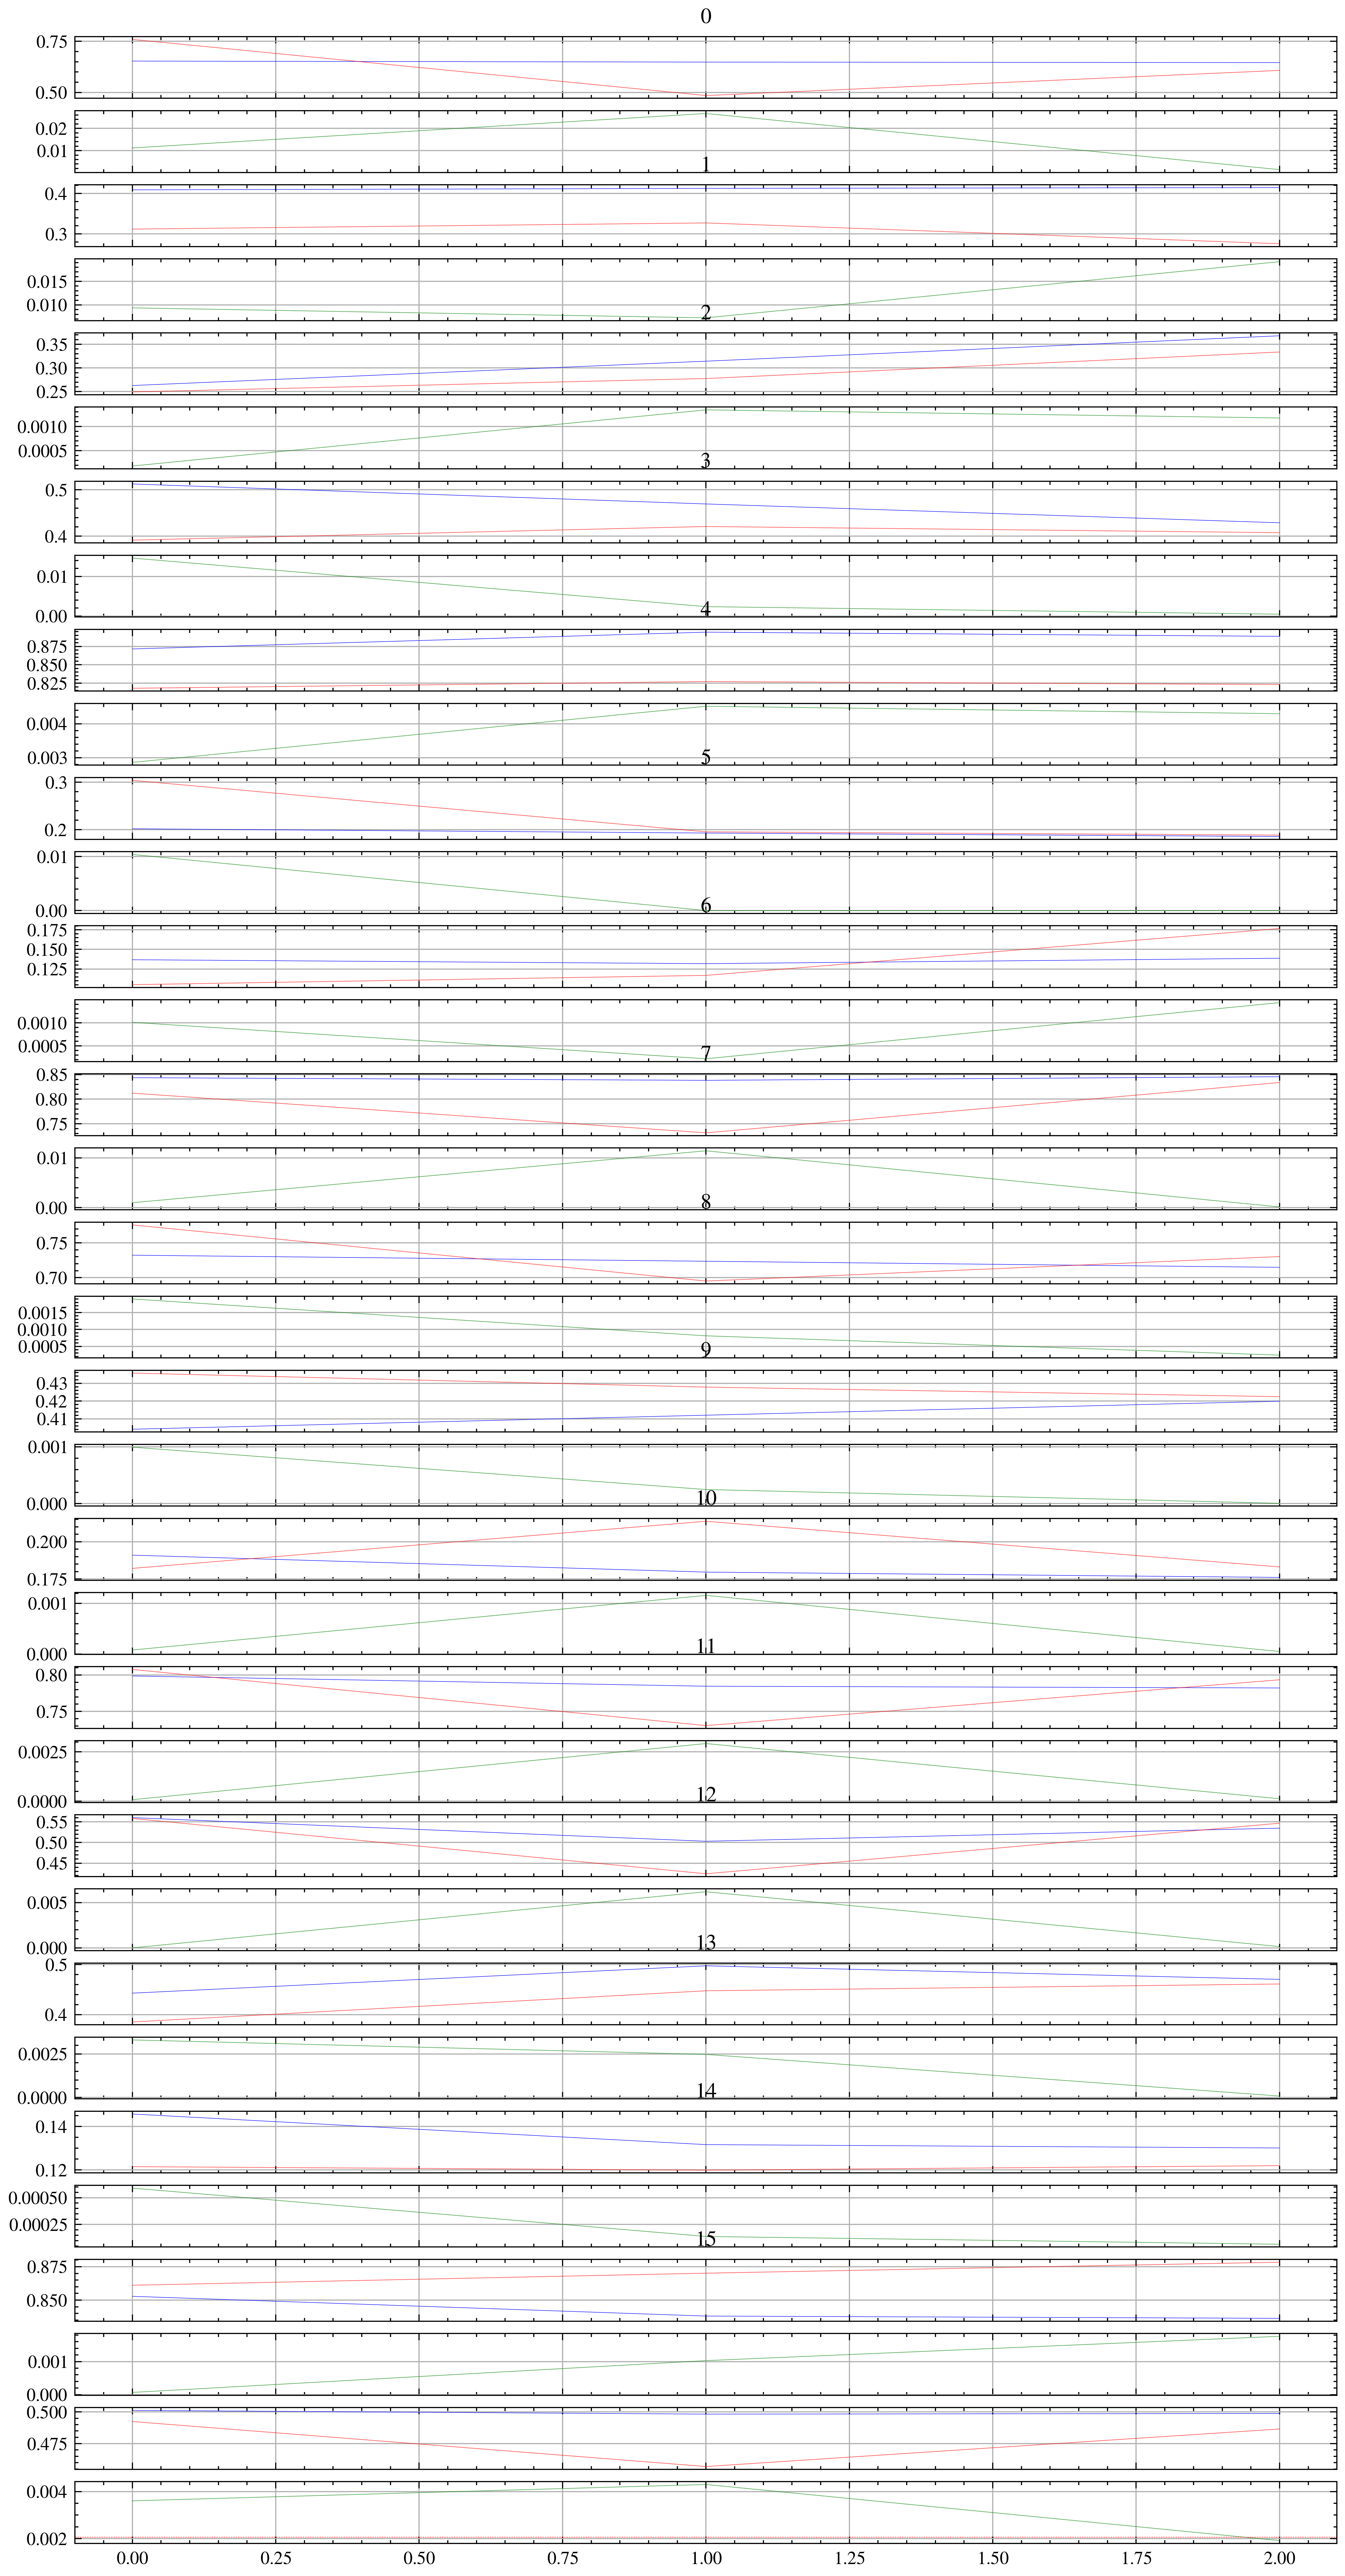

In [72]:
plot_group(f, 4924, 0.002055952745905949)

In [8]:
def eval_group_20_10(h5file, group_idx):
    values = h5file['test'][:, group_idx]
    test = torch.tensor(values, device=device)
    out = model(test)
    if isinstance(out, tuple): out = out[2]
    l = loss(out, test).detach().cpu().numpy()[0]
    return out.detach().cpu().numpy(), l


def plot_group_20_10(h5file, group, thresh, cut_start=True):
    group_idx = h5file['test_labels'][:, 2] == group
    values = h5file['test'][10:, group_idx].reshape(-1, h5file['test'].shape[2])
    # labels = h5file['test_labels'][group_idx, 0]
    
    preds, l = eval_group2(h5file, group_idx)
    preds = preds.reshape(-1, preds.shape[2])
    l = np.mean(l, axis=(0, 2))
    fig, axes = plt.subplots(nrows=2 * (values.shape[1] + 1), ncols=1, sharex=True, figsize=(10, 20))
    
    for i in range(0, values.shape[1] * 2, 2):
        feat = i // 2
        axes[i].title.set_text(str(feat))
        axes[i].plot(smooth(values[:, feat]), linewidth=0.2, color='b')
        axes[i].plot(smooth(preds[0, :, feat]), '-', alpha=0.6, linewidth=0.3, color='r')
        axes[i].grid()
        
        axes[i + 1].plot(smooth(l[:, feat]), '-', alpha=0.6, linewidth=0.3, color='g')
        axes[i + 1].grid()

    axes[-2].plot(smooth(values.mean(axis=1)), linewidth=0.2, color='b')
    axes[-2].plot(smooth(preds[0, :].mean(axis=1)), '-', alpha=0.6, linewidth=0.3, color='r')
    axes[-2].grid()
    
    axes[-1].plot(smooth(l.mean(axis=1)), '-', alpha=0.6, linewidth=0.3, color='g')
    axes[-1].axhline(y=thresh, color='r', linestyle='--', linewidth=0.2, label='Threshold')
    axes[-1].grid()

loaded test
torch.Size([10, 21277, 17])
